# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

### About COVID-19 Dataset
A database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19 dataset contains 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tqdm import tqdm
import cv2

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

sns.set_style("whitegrid")

torch.manual_seed(0)

In [2]:
print('cuda available' if torch.cuda.is_available() else 'cuda not available')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

cuda available
device: cuda:0


# Data Preparation

In [3]:
class_names = ['normal', 'viral', 'covid', 'lung']
class_fullnames = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung Opacity']

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
root_dir = 'COVID-19_Radiography_Dataset'

test_cases = 100
valid_cases = 100
num_classes = len(class_names)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def create_split(split):
    if not os.path.isdir(os.path.join(root_dir, split)):
        os.mkdir(os.path.join(root_dir, split))

        if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
            for i, d in enumerate(source_dirs):
                os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

        for c in class_names:
            os.mkdir(os.path.join(root_dir, split, c))

        for c in class_names:
            images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
            selected_images = random.sample(images, test_cases)

            for image in selected_images:
                source_path = os.path.join(root_dir, c, image)
                target_path = os.path.join(root_dir, split, c, image)
                shutil.move(source_path, target_path)
            
create_split('valid')
create_split('test')

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform=None):
        def get_images(class_name):
            images = []
            for x in os.listdir(image_dirs[class_name]):
                if x.lower().endswith('png'):
                    images.append(os.path.join(image_dirs[class_name], x))
            return images
        
        self.images = []
        self.labels = []
        for i, class_name in enumerate(image_dirs):
            class_images = get_images(class_name)
            self.images += class_images
            self.labels += [i] * len(class_images)        
        self.labels = np.array(self.labels)

        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        class_id = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, class_id

In [5]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                          std=std)])

test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                          std=std)])

In [6]:
train_dirs = {p : os.path.join(root_dir, p) for p in class_names}
test_dirs = {p : os.path.join(root_dir, 'test', p) for p in class_names}
valid_dirs = {p : os.path.join(root_dir, 'valid', p) for p in class_names}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
test_dataset = ChestXRayDataset(test_dirs, test_transform)
valid_dataset = ChestXRayDataset(valid_dirs, test_transform)

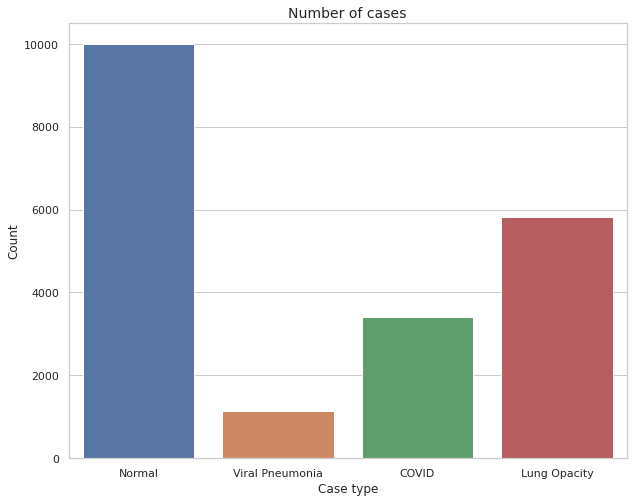

In [215]:
cases_count = []
for idx in range(num_classes):
    cases_count.append(np.sum(train_dataset.labels == idx))
    
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=class_fullnames, y=cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [251]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [181]:
def show_images(images, labels, preds):
    plt.figure(figsize=(20,6))
    for i, image in enumerate(images):
        if i > 4:
            break
        plt.subplot(1, 5, i+1, xticks=[], yticks=[])
        image = image.cpu().detach().numpy().transpose((1,2,0))
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        plt.xlabel(f'{class_fullnames[int(labels[i].numpy())]}')

Augmented data:


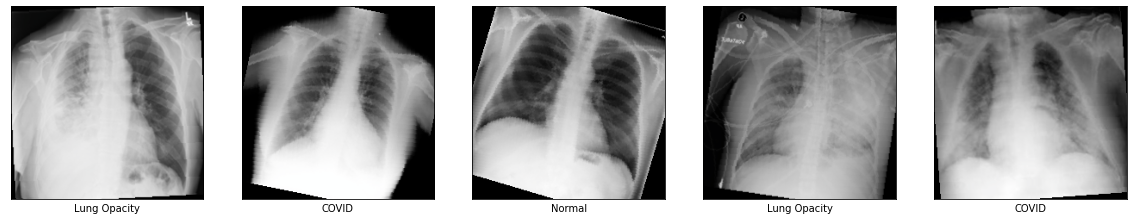

In [182]:
images, labels = next(iter(train_loader))
print('Augmented data:')
show_images(images, labels, labels)

# Modeling

In [14]:
resnet18 = models.resnet18(pretrained=True)

In [15]:
summary(resnet18.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [20]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [21]:
resnet18 = resnet18.to(device)

In [22]:
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [164]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes), class_names, rotation=50)
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
def show_images_with_preds(images, labels, soft_preds):
    plt.figure(figsize=(14,6))
    _, preds = torch.max(soft_preds, 1)

    for i, image in enumerate(images):
        if i > 4:
            break
            
        plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        image = image.cpu().detach().numpy().transpose((1,2,0))
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        

        if preds[i] == labels[i]:
            col = 'blue'
        else:
            col = 'red'
        
        plt.xlabel("{} {:2.0f}% (truth: {})".format(class_names[int(preds[i].numpy())],
                                100*np.max(soft_preds[i].numpy()),
                                class_names[labels[i]]),
                                color=col)
        
        plt.subplot(2, 5, 6+i, xticks=[], yticks=[])
        plot_value_array(i, soft_preds[i], labels)
        
    plt.tight_layout()
    plt.show()
    
def visualize_preds():
    resnet18.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = resnet18(images)
    outputs = outputs.cpu().detach()    
    soft_preds = torch.softmax(outputs, dim=1)   
    
    show_images_with_preds(images, labels, soft_preds)

Predictions before training


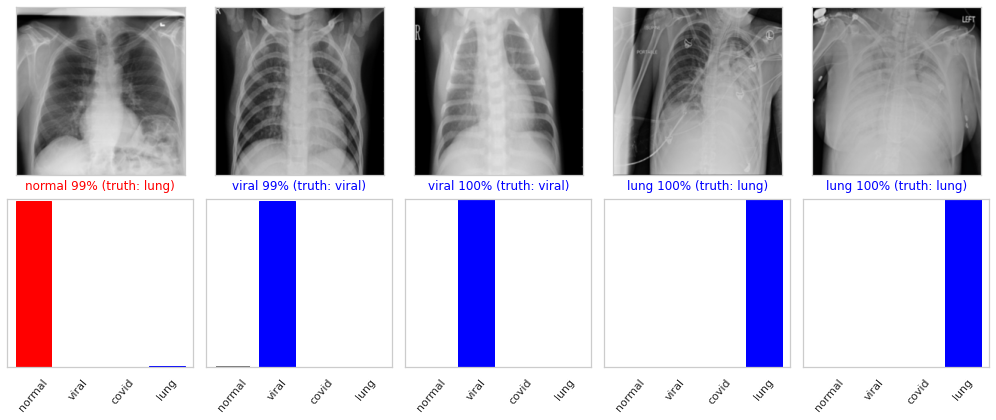

In [213]:
print('Predictions before training')
visualize_preds()

In [166]:
train_losses = []
train_accuracies = []

def train(epoch):
    
    print('\nEpoch : %d' % epoch)

    resnet18.train()
    running_loss = 0
    correct = 0
    total = 0      
    
    for data in tqdm(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
      
    train_loss = running_loss / len(train_loader)
    acc = 100. * correct / total
  
    train_accuracies.append(acc)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f' % (train_loss, acc))          

In [167]:
eval_losses = []
eval_accuracies = []

def test(epoch):
    resnet18.eval()

    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(valid_loader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    test_loss = running_loss / len(valid_loader)
    acc = 100. * correct / total

    eval_losses.append(test_loss)
    eval_accuracies.append(acc)

    print('Test Loss: %.3f | Accuracy: %.3f' % (test_loss, acc)) 

In [168]:
epochs = 10
for epoch in range(1, epochs + 1): 
    train(epoch)
    test(epoch)


Epoch : 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:50<00:00, 11.57it/s]


Train Loss: 0.381 | Accuracy: 86.202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Test Loss: 0.183 | Accuracy: 94.750

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:45<00:00, 12.04it/s]


Train Loss: 0.232 | Accuracy: 91.716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.82it/s]


Test Loss: 0.210 | Accuracy: 92.250

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:47<00:00, 11.80it/s]


Train Loss: 0.194 | Accuracy: 93.125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.77it/s]


Test Loss: 0.126 | Accuracy: 96.000

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:45<00:00, 12.10it/s]


Train Loss: 0.165 | Accuracy: 94.383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.63it/s]


Test Loss: 0.183 | Accuracy: 93.250

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:41<00:00, 12.50it/s]


Train Loss: 0.155 | Accuracy: 94.643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.72it/s]


Test Loss: 0.125 | Accuracy: 96.250

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:41<00:00, 12.53it/s]


Train Loss: 0.139 | Accuracy: 95.124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.80it/s]


Test Loss: 0.130 | Accuracy: 96.000

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:47<00:00, 11.84it/s]


Train Loss: 0.127 | Accuracy: 95.527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.00it/s]


Test Loss: 0.108 | Accuracy: 97.000

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:46<00:00, 11.99it/s]


Train Loss: 0.115 | Accuracy: 95.880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.01it/s]


Test Loss: 0.186 | Accuracy: 95.000

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:45<00:00, 12.09it/s]


Train Loss: 0.103 | Accuracy: 96.317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.10it/s]


Test Loss: 0.133 | Accuracy: 95.750

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1273/1273 [01:53<00:00, 11.19it/s]


Train Loss: 0.102 | Accuracy: 96.406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]

Test Loss: 0.172 | Accuracy: 95.250


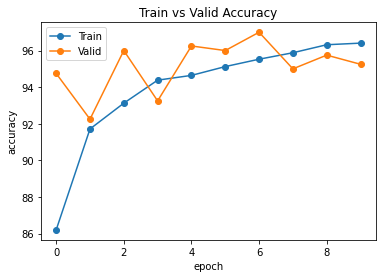

In [169]:
plt.plot(train_accuracies,'-o')
plt.plot(eval_accuracies,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

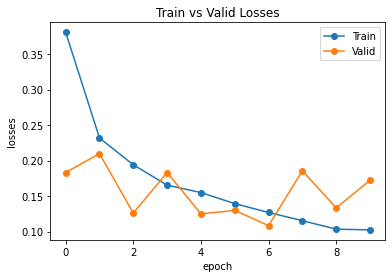

In [170]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

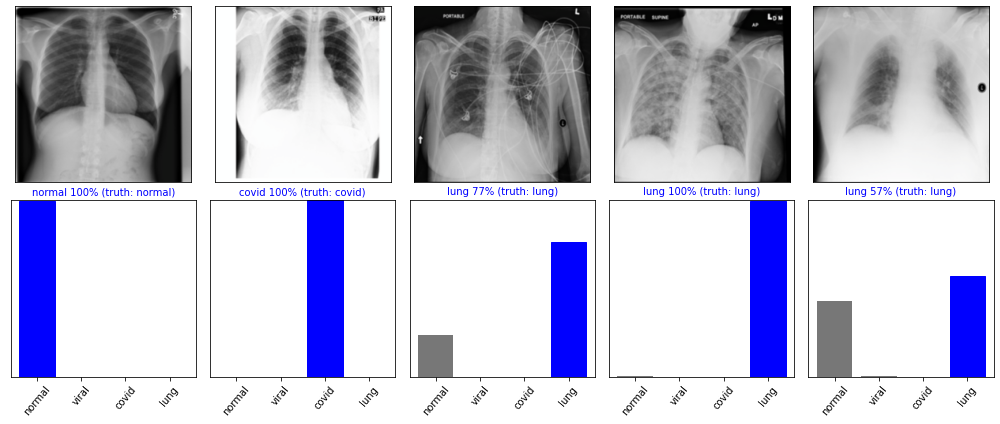

In [171]:
visualize_preds()

In [209]:
def eval_classifier(model, test_loader, plot_roc_curve = False):
    
    def indices_to_one_hot(data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)
        return np.eye(nb_classes)[targets]
    
    model.eval()
           
    score_list   = torch.Tensor([])
    pred_list    = torch.Tensor([]).long()
    target_list  = torch.Tensor([]).long()
    
    for iter_num, (images, labels) in enumerate(test_loader):        
        images, labels = images.to(device), labels.to(device)        
        outputs = model(images)                
        labels = labels.cpu().detach()    
        outputs = outputs.cpu().detach()        
        score_list   = torch.cat([score_list, torch.nn.Softmax(dim = 1)(outputs).squeeze()])
        target_list  = torch.cat([target_list, labels.squeeze()])
        _, preds = torch.max(outputs, 1)
        pred_list = torch.cat([pred_list, preds.squeeze()])
    
    pred_list   = pred_list.numpy()
    target_list = target_list.numpy()
    score_list  = score_list.numpy()
    accuracy = np.sum(target_list == pred_list) / len(pred_list) * 100.
    
    print(f'Total accuracy: {accuracy}%')
    
    cm  = confusion_matrix(target_list, pred_list) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    
    plot_confusion_matrix(cm, hide_ticks=True, cmap=plt.cm.Blues, axis=axes[0])
    
    axes[0].set_xlabel('Predicted labels', fontsize=12)
    axes[0].set_ylabel('True labels', fontsize=12)    
    axes[0].set_xticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_yticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_title('Confusion Matrix', fontsize=16)
    
    target_list = indices_to_one_hot(target_list, num_classes)
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(target_list[:, i], score_list[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(num_classes):
        
        axes[1].plot(fpr[i], tpr[i], label=f'{class_fullnames[i]} (area = %0.5f)' % roc_auc[i])
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])

        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve', fontsize=16)
        axes[1].legend(loc="lower right")
        
    plt.tight_layout()  
    plt.show()
    
    return score_list

Total accuracy: 94.0%


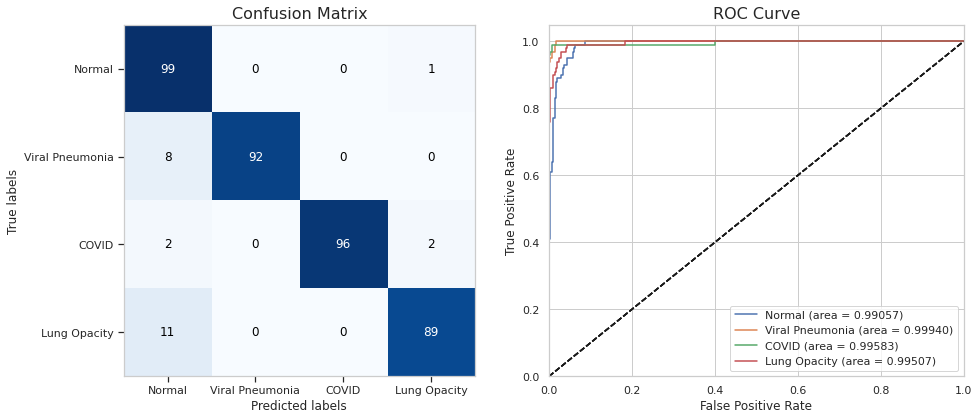

In [214]:
scores = eval_classifier(resnet18, test_loader)

In [216]:
!pip install grad-cam

     |████████████████████████████████| 1.8 MB 6.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=0d35f14a5614caa0fc9003f010fcec2c333319f22ad55120db14d438a8d1a10b
  Stored in directory: /home/fodics/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam


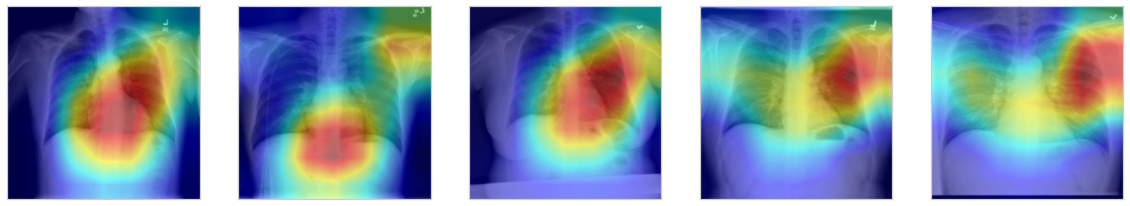

In [302]:
resnet18 = resnet18.cpu()

images, labels = next(iter(test_loader))

target_layers = [resnet18.layer4[-1]]
input_tensor = images 
target_category = labels

cam = GradCAM(model=resnet18, target_layers=target_layers, use_cuda=True)

grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

plt.figure(figsize=(20,6))

for i in range(5):
    
    image_path = test_dataset.images[i]
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255

    plt.subplot(1, 5, i+1, xticks=[], yticks=[])        
    cam = grayscale_cam[i, :]
    visualization = show_cam_on_image(rgb_img, cam, use_rgb=True)

    plt.imshow(visualization)